<a href="https://colab.research.google.com/github/salimnh/Louis-Dreyfus-Challenge/blob/master/LDC_lstmAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study Case: Binary Classifier

The challenge we suggest is to build a binary classifier to forecast if a vessel in the pacific polygon (P) will go through the Panama Canal in the next 30 days. Note that this is an imbalanced dataset as most vessels do not go through the Panama canal.



### Data set


**imo:** the unique identifier by vessel.

**date:** the date at which the observation was made. Thanks to a preliminary script on R, we observe that the number of vessels per day in the region is stationary on two regimes. A low regime between April and June. And a high regime the rest of the year.
About 1/3 of the vessels are allocated in the east of the canal and 2/3 in the west.
The most important thing is that the fraction of vessels going through the canal among all vessels per day is stationary over time. This observation will allow us to no longer take into account the date and thus to simply consider ordered sequences. 

**longitude, latitude:** the daily position of the vessel.These observations will be transformed into polar coordinates x y z, then normalized. to avoid problems related to the coordination at -180 deg.

**bearing:** the direction in which the vessel is going (computed from 2 consecutive points). this variable has too much missing data. it can be completed by a calculation on two coordinates. But it will be omitted because this information is already present in the polar coordinate sequences.

**destination:** the destination input manually by the master of the vessel. This data will be omitted because in the case of bulck vessels it cannot be considered reliable.

**zone:** True if the vessel is in polygon (CP), False if he is in (P). This data will be modified for use. We're trying to find out if a vessel passes through the panama. So for each vessel we will note 1 if we observe a change in status in this variable 0 otherwise. The column is called 'Tpanama'. That's the one we're trying to predict.
We will see that the number of 1 is very small compared to the total number of observation. We have already been warned in the problem statement.

**draft:** the draft of the fleet.This feature can be a good metric of the filling of a vessel. It may be important for our study.

**statusLDC:** the status of the vessel (laden,ballast,unsure).

**size:** the size of the vessel. 3 levels

### Model Idea
The idea is to build a binary classification model. We are placed in the context of prediction of a rare event.

A good framework to do this is to use an autoencoder.

Also we want to capture the temporal effects, for that we will use an lstm in the multivariate case which allows to take into account the events in the long term as well as in the short term.

The lstm is used with shift response data to be able to learn in advance and a sliding window.Unfortunately, this architecture does not allow learning from all ships.
We will therefore take one reference vessel per size category (highest in term of observation per category 'size' ).

The same work can be improved by performing trajectory clustering rather than vessels sizes such as grouping.

### Improvement
Use padding methods and use the 'sentiment analysis' binary classifier framework.
 
see next script

### Importing package


In [0]:
#set up
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

import seaborn as sns

from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)
from sklearn.model_selection import train_test_split


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


### Util Function



Get the mid value between two point.
Finally this function will not be used. The assumption behind is that if there are some missing lon lat for some dates we assume that the vessel is at the docks.

In [0]:
def midpoint(x1, y1, x2, y2):
#Input values as degrees

#Convert to radians
    lat1 = math.radians(x1)
    lon1 = math.radians(x2)
    lat2 = math.radians(y1)
    lon2 = math.radians(y2)


    bx = math.cos(lat2) * math.cos(lon2 - lon1)
    by = math.cos(lat2) * math.sin(lon2 - lon1)
    lat3 = math.atan2(math.sin(lat1) + math.sin(lat2), \
           math.sqrt((math.cos(lat1) + bx) * (math.cos(lat1) \
           + bx) + by**2))
    lon3 = lon1 + math.atan2(by, math.cos(lat1) + Bx)

    return [round(math.degrees(lat3), 2), round(math.degrees(lon3), 2)]


Get the Cartesian values from lon & lat. 
This function is used to prepare Input for the lstm.

In [0]:
def get_cartesian(lat=None,lon=None):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return pd.DataFrame(list(zip(x, y, z)), 
               columns =['X', 'Y', 'Z'])

Add the binary output (column name: Tpanama).
= 1 if the vessel go trought Panama canal at this period.
= 0 otherwize

In [0]:
def get_Panama(all_df):

  all_df['Tpanama'] = all_df['zone'].astype(int).reset_index(drop=True)
  all_df['Tpanama']=all_df.groupby(['imo'])['Tpanama'].diff(1).fillna(0).reset_index(drop=True)
  all_df['Tpanama']= all_df['Tpanama'].abs()
  all_df
  return all_df

For some vessels there are long periods of missing data. By observing the last value we realize that the ship is actually at the docks.
We therefore want to capture this information.
For this purpose we will fill in the missing dates with the last observed value

In [0]:
def fill_date(df,imo_ticker):
  rep_df=df.loc[df.imo== imo_ticker][['Tpanama','date','latitude','longitude']].reset_index(drop=True)
  #fill missing date
  rep_df['date']=pd.to_datetime(rep_df['date'])

  idx = pd.date_range(rep_df['date'].min(),rep_df['date'].max())
  fill_df = pd.DataFrame({'date':idx})

  fill_df = fill_df.merge(rep_df, on='date', how='left')
  fill_df[['latitude','longitude']]=fill_df[['latitude','longitude']].fillna(method='ffill')
  fill_df['Tpanama']=fill_df['Tpanama'].fillna(0)
  return fill_df

In [0]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y

In [0]:
def flatten(X):
 
 
    
    #Input : X ,          A 3D array for lstm, where the array is sample x timesteps x features.
    
    #Output: flattened_X,  A 2D array, sample x features.
  
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
 
    
  #  Inputs: X,            A 3D array for lstm, where the array is sample x timesteps x features.
  #         scaler:       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
  # Output: X ,           Scaled 3D array.
    
  
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

### Import Data set

In [0]:
#import data set

path2='/content/gdrive/My Drive/exoPanama.csv'
all_df=pd.read_csv(path2)

all_df.head()
df=all_df

In [0]:
#present data set in suitable way
#sorted by imo and date
df= df.sort_values(by=['imo','date']).reset_index(drop=True)
df=get_Panama(df)
df.head()


,Column1,imo,date,latitude,longitude,destination,bearing,size,zone,statusLDC,draft,Tpanama
0,148121,7526572,11/23/2012,29.074500,-94.453017,NaN,NaN,PMX,True,ballast,0.0,0.0
1,162529,7621932,01/01/2012,29.949669,-90.025619,PANAMA,NaN,PMX,True,laden,12.1,0.0
2,162530,7621932,01/03/2012,29.949684,-90.025589,PANAMA,NaN,PMX,True,laden,12.1,0.0
3,162531,7621932,01/04/2012,29.949654,-90.025589,PANAMA,NaN,PMX,True,laden,12.1,0.0
4,162532,7621932,01/05/2012,29.949631,-90.025581,PANAMA,NaN,PMX,True,laden,12.1,0.0


In [0]:
#count number of observation per vessels
n_vessel=df['imo'].value_counts()
pd.DataFrame(n_vessel).head()

,imo
7700726,1943
8312215,1705
9138094,1672
9034925,1601
9115523,1532


In [0]:
n_vessel.describe()

count    3601.000000
mean      157.068037
std       157.127327
min         1.000000
25%        53.000000
50%       117.000000
75%       218.000000
max      1943.000000
Name: imo, dtype: float64

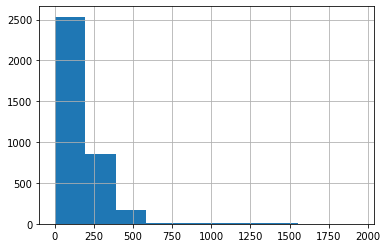

In [0]:

pd.Series.hist(n_vessel,)



In [0]:
vessels_size_n=df.groupby(['imo','size']).size().reset_index()
vessels_size_n.head()

,imo,size,0
0,7526572,PMX,1
1,7621932,PMX,173
2,7700726,PMX,1943
3,7915412,PMX,558
4,7926148,PMX,1206


In [0]:
#Filter data set to find vessels that crossed panama canal
isPanama = set(df[(df['Tpanama'] == 1 )]['imo'])
Panamadf=df[df['imo'].isin(isPanama)]

#whithin the bucket of vessel that crossed the panama count number of observation
Count_v=Panamadf.groupby(['imo','size']).size().reset_index()
Count_v.head()

,imo,size,0
0,7621932,PMX,173
1,7915412,PMX,558
2,7926174,PMX,1298
3,8005276,PMX,39
4,8007793,PMX,1109


In [0]:
#We are looking for one representative vessel per size category
vessel_p=Panamadf.groupby(['imo','size'], as_index = False)['Tpanama'].agg(['sum','count']).reset_index()
vessel_p['Ratio'] = vessel_p['sum']/vessel_p['count']
vessel_p.head(100)

,imo,size,sum,count,Ratio
0,7621932,PMX,3.0,173,0.017341
1,7915412,PMX,54.0,558,0.096774
2,7926174,PMX,58.0,1298,0.044684
3,8005276,PMX,4.0,39,0.102564
4,8007793,PMX,42.0,1109,0.037872
...,...,...,...,...,...
95,9077109,PMX,4.0,207,0.019324
96,9077226,PMX,6.0,172,0.034884
97,9077238,PMX,5.0,135,0.037037
98,9079133,PMX,224.0,627,0.357257


In [0]:
#find the bigest by size
top_vessel_p=vessel_p.sort_values('count', ascending=False).drop_duplicates(['size'])
top_vessel_p.head()


,imo,size,sum,count,Ratio
12,8312215,PMX,100.0,1705,0.058651
199,9148611,CAPE,36.0,724,0.049724
771,9325295,VLOC,9.0,195,0.046154


In [0]:
#Find representative vessels for each category

rep_PMX=top_vessel_p.imo[top_vessel_p['size']=="PMX"].values[0]
rep_CAPE=top_vessel_p.imo[top_vessel_p['size']=="CAPE"].values[0]
rep_VLOC=top_vessel_p.imo[top_vessel_p['size']=="VLOC"].values[0]


In [0]:
#Select a vessel
rep_vessel=rep_PMX

rep_df=df.loc[df.imo== rep_vessel][['Tpanama','date','latitude','longitude']].reset_index(drop=True)
rep_df.head()

,Tpanama,date,latitude,longitude
0,0.0,01/01/2012,20.769934,-86.733734
1,0.0,01/01/2013,22.416117,-84.709033
2,0.0,01/01/2014,23.262287,-87.851647
3,0.0,01/01/2016,22.906900,-87.523500
4,0.0,01/01/2017,29.944400,-90.141900


In [0]:
#fill missing dates
fill_df=fill_date(df,rep_vessel)
fill_df.head()

,date,Tpanama,latitude,longitude
0,2012-01-01,0.0,20.769934,-86.733734
1,2012-01-02,0.0,28.463751,-89.196587
2,2012-01-03,0.0,28.463751,-89.196587
3,2012-01-04,0.0,30.044867,-90.837486
4,2012-01-05,0.0,30.041983,-90.602715


In [0]:
# get x y z coord from lon,lat
cord=get_cartesian(lat=fill_df[fill_df.columns[2]],lon=fill_df[fill_df.columns[3]])
fill_df[['X','Y','Z']] = cord[['X','Y','Z']]

#final data set
clean_df = fill_df.drop(columns=['latitude', 'longitude','date'])
clean_df.head()


,Tpanama,X,Y,Z
0,0.0,339.40512,-5947.283894,2259.260818
1,0.0,78.53394,-5600.315382,3036.435581
2,0.0,78.53394,-5600.315382,3036.435581
3,0.0,-80.60859,-5514.362553,3189.819570
4,0.0,-58.01434,-5514.807095,3189.541979


In [0]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################

### Model


In [0]:


SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Panama"]


In [0]:
sign = lambda x: (1, -1)[x < 0]

   # This function will shift the binary labels in the dataframe.
   


    
   # Inputs:
   # df dataframe with a binary labeled column. 
   #         This labeled column is named 'Tpanama'.
   #    shift_by An integer denoting the number of rows to shift.
    
   # Output
   # df       A dataframe with the binary labels shifted by shift.

def curve_shift(df, shift_by):
    vector = df['Tpanama'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'Tpanama'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [0]:
# Positive labeled rows before shifting.
one_indexes = clean_df.index[clean_df['Tpanama'] == 1]

# converts the df to a numpy array
input_X = clean_df.loc[:, clean_df.columns != 'Tpanama'].values  
input_y = clean_df['Tpanama'].values

# number of features
n_features = input_X.shape[1]  


# Shift the response column y by 30 rows to do a 30 days ahead prediction.
clean_df = curve_shift(clean_df, shift_by = -30)
clean_df.head()


,Tpanama,X,Y,Z
0,0.0,339.40512,-5947.283894,2259.260818
1,0.0,78.53394,-5600.315382,3036.435581
2,0.0,78.53394,-5600.315382,3036.435581
3,0.0,-80.60859,-5514.362553,3189.819570
4,0.0,-58.01434,-5514.807095,3189.541979


In [0]:
# Fixe lookback
lookback = 30

# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



In [0]:
#Split train/test set
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [0]:
# discriminate data 
# we will fisrt train only 'Tpnama'=0
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [0]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [0]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [0]:
X_train_y0_scaled = scale(X_train_y0, scaler)

In [0]:
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.  0.  0.]
colwise variance [1. 1. 1.]


In [0]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [0]:
# equal to the lookback
timesteps =  X_train_y0_scaled.shape[1] 

# 3 features  (draft could be added, here omited for simplicity)
n_features =  X_train_y0_scaled.shape[2] 

epochs = 100
batch = 64
lr = 0.0001

In [0]:
# Model
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 30, 128)           67584     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
lstm_20 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 3)             387       
Total params: 249,219
Trainable params: 249,219
Non-trainable params: 0
________________________________________________

In [0]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Train on 1162 samples, validate on 286 samples
Epoch 1/100
 - 12s - loss: 0.9741 - val_loss: 0.9114
Epoch 2/100
 - 4s - loss: 0.9575 - val_loss: 0.8872
Epoch 3/100
 - 4s - loss: 0.8950 - val_loss: 0.7179
Epoch 4/100
 - 4s - loss: 0.7434 - val_loss: 0.7065
Epoch 5/100
 - 4s - loss: 0.6424 - val_loss: 0.5732
Epoch 6/100
 - 4s - loss: 0.5492 - val_loss: 0.5400
Epoch 7/100
 - 4s - loss: 0.5120 - val_loss: 0.5097
Epoch 8/100
 - 4s - loss: 0.4738 - val_loss: 0.4796
Epoch 9/100
 - 4s - loss: 0.4488 - val_loss: 0.4608
Epoch 10/100
 - 4s - loss: 0.4288 - val_loss: 0.6011
Epoch 11/100
 - 4s - loss: 0.4218 - val_loss: 0.4473
Epoch 12/100
 - 4s - loss: 0.4123 - val_loss: 0.4444
Epoch 13/100
 - 4s - loss: 0.4072 - val_loss: 0.4328
Epoch 14/100
 - 4s - loss: 0.3998 - val_loss: 0.4307
Epoch 15/100
 - 4s - loss: 0.4141 - val_loss: 0.4604
Epoch 16/100
 - 4s - loss: 0.4165 - val_loss: 0.4445
Epoch 17/100
 - 4s - loss: 0.4014 - val_loss: 0.4360
Epoch 18/100
 - 4s - loss: 0.3950 - val_loss: 0.4290
Epoch 1

In [0]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

NameError: ignored

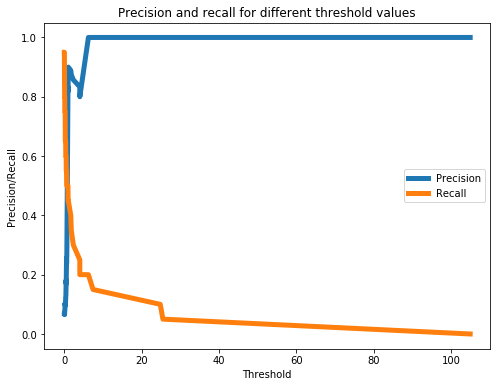

In [0]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [0]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.9
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Panama" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

NameError: ignored

In [0]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

NameError: ignored

In [0]:
conf_matrix

array([[357,   7],
       [  5,  14]])

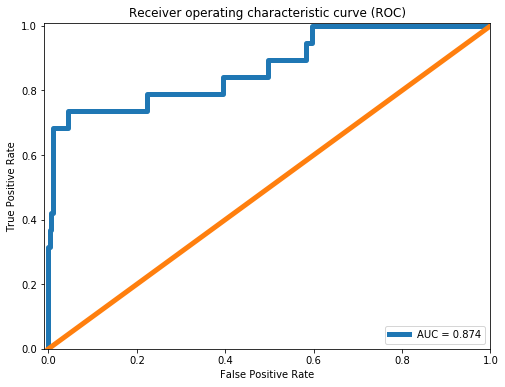

In [0]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()